# **CIS 5450 Final Project - Porter Delivery Time Prediction**
*Daniel Rohacs, Patrick Wu, Aditya Sirohi*

# **Part 1: Introduction**

We did this project.
- Porter is India's largest intra-city logistics company.


https://pitchbook.com/profiles/company/111521-26#overview
"Operator of an online logistics marketplace intended to offer a standardized service for the utilization of trucks. The company's platform permits businesses to book mini trucks/tempo from a fleet of vehicles as per the date and location, enabling businesses to have access to reliable and economical mini truck booking and letting them track their rides in real time."


- Our goal was to a) develop a model that will be helpful to tell users prediction times b) do inference on how to improve delivery times

# **Part 2: Data Loading & Cleaning**

The first step is to import all the relevant libraries for this project. We will be using the libraries listed below:
1. Pandas: store, understant, and clean the data
2. Seaborn and matplotlib: Data visulaization
3. Numpy, statsmodels, and scipy.stats: statistical analysis and modification of the data

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
import pandasql as ps
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from skopt import gp_minimize
from sklearn.ensemble import RandomForestRegressor
from itertools import product

# **2.1: Data Loading**

To begin our analysis, we'll first need to load our data. Luckily, we didn't do anything too fancy here. We will load "porter_data.csv" into a pandas dataframe and display the first 10 rows. This data can be found at https://www.kaggle.com/datasets/ranitsarkar01/porter-delivery-time-estimation-dataset/data.

In [ ]:
porter_df = pd.read_csv("porter_data.csv")
porter_df.head(10)

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:11:17,4,1.0,4,3441,4,557,1239,33.0,14.0,21.0,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:33:25,46,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,690.0
2,2.0,2015-02-16 00:11:35,2015-02-16 01:06:35,36,3.0,4,4771,3,820,1604,8.0,6.0,18.0,289.0
3,1.0,2015-02-12 03:36:46,2015-02-12 04:35:46,38,1.0,1,1525,1,1525,1525,5.0,6.0,8.0,795.0
4,1.0,2015-01-27 02:12:36,2015-01-27 02:58:36,38,1.0,2,3620,2,1425,2195,5.0,5.0,7.0,205.0
5,1.0,2015-02-06 00:42:42,2015-02-06 01:38:42,38,1.0,3,4475,3,925,1825,4.0,1.0,1.0,542.0
6,1.0,2015-02-08 02:04:17,2015-02-08 03:07:17,38,1.0,3,4375,3,1325,1625,6.0,4.0,3.0,789.0
7,1.0,2015-01-31 04:35:54,2015-01-31 05:33:54,38,1.0,2,3150,2,1425,1725,4.0,9.0,12.0,548.0
8,1.0,2015-01-31 02:21:23,2015-01-31 02:58:23,46,1.0,2,950,2,150,700,24.0,24.0,26.0,212.0
9,1.0,2015-01-31 23:45:12,2015-02-01 00:26:12,46,1.0,5,1285,3,150,400,12.0,13.0,11.0,424.0


And this looks good -- we'll likely need to process the created_at and actual_delivery_time features, but luckily, the rest of our features seem to be already encoded in a reasonable manner and non-null. Let's verify that.

In [ ]:
# Check for null values
porter_df.isna().sum()

market_id                                       0
created_at                                      0
actual_delivery_time                            0
store_primary_category                          0
order_protocol                                  0
total_items                                     0
subtotal                                        0
num_distinct_items                              0
min_item_price                                  0
max_item_price                                  0
total_onshift_dashers                           0
total_busy_dashers                              0
total_outstanding_orders                        0
estimated_store_to_consumer_driving_duration    0
dtype: int64

Now let's take a look at the datatypes we're given and some summary statistics.

In [ ]:
porter_df.dtypes

market_id                                       float64
created_at                                       object
actual_delivery_time                             object
store_primary_category                            int64
order_protocol                                  float64
total_items                                       int64
subtotal                                          int64
num_distinct_items                                int64
min_item_price                                    int64
max_item_price                                    int64
total_onshift_dashers                           float64
total_busy_dashers                              float64
total_outstanding_orders                        float64
estimated_store_to_consumer_driving_duration    float64
dtype: object

Let's outline these features a little more.
- market_id (float64): market ID for the resturant's location. There are 6 unique locations with the values 1 - 6
- created_at (object): this is when the order is placed
- actual_delivery_time (object): this is when the ordered was delivered
- store_primary_category (int64): resturant category (72 unique resturant categories)
- order_protocol (float64): this is how the order was placed (mobile, phone call, prebooked, third party). Values ranges from 1-7
- total_items (int64): number of items ordered
- subtotal (int64): total price of the order
- num_distinct_items (int64): the unique number of items in the order
- min_item_price (int64): the lowest price of an item in the order
- max_item_price (int64): the highest price of an item in the order
- total_onshift_dashers (float64): number of dashers active in the system
- total_busy_dashers (float64): number of dashers currently on a delivery
- total_outstanding_orders (float64): orders that still need to be compleated
- estimated_store_to_consumer_driving_duration (float64): travel time between the store and the delivery location

In [ ]:
porter_df.describe(include='all')

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration
count,175777.000000,175777,175777,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000
unique,NaN,162649,160344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2015-02-11 19:50:43,2015-02-14 03:01:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,6,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.743726,NaN,NaN,35.887949,2.911752,3.204976,2697.111147,2.675060,684.965433,1160.158616,44.918664,41.861381,58.230115,546.077240
std,1.330963,NaN,NaN,20.728254,1.513128,2.674055,1828.554893,1.625681,519.882924,560.828571,34.544724,32.168505,52.731043,218.717798
min,1.000000,NaN,NaN,0.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000
25%,2.000000,NaN,NaN,18.000000,1.000000,2.000000,1412.000000,1.000000,299.000000,799.000000,17.000000,15.000000,17.000000,384.000000
50%,2.000000,NaN,NaN,38.000000,3.000000,3.000000,2224.000000,2.000000,595.000000,1095.000000,37.000000,35.000000,41.000000,544.000000
75%,4.000000,NaN,NaN,55.000000,4.000000,4.000000,3410.000000,3.000000,942.000000,1395.000000,66.000000,63.000000,85.000000,703.000000


This looks mostly reasonable, and we'll do most of our analysis during the EDA where we can see the actual distribution of underlying variables and their correlations.

One thing I will note is that, sometimes, we have negative total_outstanding_orders, total_busy_dashers, and total_onshift_dashers. We will need to clean these sections of our data before moving forward.

# **2.2 Adding Features**

Before moving forward, let's define some additional features.

We will first parse created_at and actual_delivery_time to be datetimes. Upon examining the values for the two variables, we notice that the times are in California time and need to be converted to Indian time. The distribution of hour_of_day is most reasonable with this choice of timezones (if we don't we find that business hours are the only hours with no activity). To do this, we will first convert the columns to the datetime and then use the localize to change the time zones.

In [ ]:
porter_df["created_at"] = pd.to_datetime(porter_df["created_at"]).dt.tz_localize('America/Los_Angeles')
porter_df["created_at"] = porter_df["created_at"].dt.tz_convert('Asia/Kolkata')
porter_df["actual_delivery_time"] = pd.to_datetime(porter_df["actual_delivery_time"]).dt.tz_localize('America/Los_Angeles')
porter_df["actual_delivery_time"] = porter_df["actual_delivery_time"].dt.tz_convert('Asia/Kolkata')

Now we can add the additional features.
- delivery_time (float64): The time (in minutes) it took to delivery the items. This is our target variable.
- day_of_week (int64): The day of week the order was placed (and delivered!).
- hour_of_day (int64): The hour of day the delivery was placed.

In [ ]:
porter_df["delivery_time"] = (porter_df["actual_delivery_time"] - porter_df["created_at"]).dt.total_seconds() / 60
porter_df["day_of_week"] = porter_df["created_at"].dt.day_of_week
porter_df["hour_of_day"] = porter_df["created_at"].dt.hour

# **2.3 Assessing Data Quality / Handling Outliers**

To ensure the veracity of our data, we will do some preliminary data cleaning.

Since we plan to do a few non-trivial queries on our dataframe, it's probably easier to do this in pandaSQL. Let's load our dataframe into pandaSQL.

In [ ]:
porter_df_temp = porter_df.copy(deep=True)
# Ensure compatability with pandaSQL
porter_df_temp["created_at"] = porter_df_temp["created_at"].astype('int64') // 10**9 / 60 / 60 / 24
porter_df_temp["actual_delivery_time"] = porter_df_temp["actual_delivery_time"].astype('int64') // 10**9 / 60 / 60 / 24
porter_df_temp["created_at"] -= porter_df_temp["created_at"].min()
porter_df_temp["actual_delivery_time"] -= porter_df_temp["created_at"].min()

# **2.3.1 Cleaning total_busy_dashers/total_onshift_dashers**

Since we plan to do a few non-trivial queries on our dataframe, it's probably easier to do this in pandaSQL. Let's load our dataframe into pandaSQL.

In [ ]:
sql_query = """
SELECT *
FROM porter_df
WHERE total_busy_dashers > total_onshift_dashers
"""

# Execute the SQL query using pandasql
tt = ps.sqldf(sql_query, locals())

porter_df.describe(include='all') - tt.describe(include='all')

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,delivery_time,day_of_week,hour_of_day
25%,1.000000,NaN,NaN,2.000000,0.000000,0.000000,-8.000000,0.000000,-1.000000,0.000000,-1.000000,-7.000000,-6.000000,-1.000000,-1.000000,0.000000,0.000000
50%,0.000000,NaN,NaN,0.000000,0.000000,0.000000,24.000000,0.000000,-4.000000,0.000000,2.000000,-8.000000,-4.000000,-5.000000,-1.000000,0.000000,0.000000
75%,0.000000,NaN,NaN,0.000000,-1.000000,0.000000,62.250000,0.000000,-8.000000,-4.000000,8.000000,-6.000000,5.000000,0.000000,-1.000000,0.000000,-1.000000
count,136487.000000,136487,136487,136487.000000,136487.000000,136487.000000,136487.000000,136487.000000,136487.000000,136487.000000,136487.000000,136487.000000,136487.000000,136487.000000,136487.000000,136487.000000,136487.000000
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,0.000000,NaN,NaN,0.000000,0.000000,354.000000,0.000000,2.000000,7441.000000,7391.000000,31.000000,0.000000,9.000000,0.000000,0.000000,0.000000,2.000000
mean,0.231942,NaN,NaN,0.196526,-0.049358,0.068605,45.609416,0.053986,-10.589924,-5.280834,4.093925,-6.960838,-0.155937,-0.647270,-1.078993,0.109056,-0.391780
min,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
std,0.047429,NaN,NaN,0.065528,-0.004754,0.234669,57.251489,0.040249,-8.271903,0.036391,6.375174,-0.649785,6.198428,1.510198,-0.629444,-0.180326,-0.045495
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It shouldn't be possible for there to be more busy dashers than onshift dashers. Let's see if this is the case in our data.

In [ ]:
weird_times_query = """
SELECT *
FROM porter_df_temp
WHERE total_busy_dashers > total_onshift_dashers
"""

porter_query = """
SELECT *
FROM porter_df_temp
"""


weird_times_sql_df = ps.sqldf(weird_times_query, locals())
porter_sql_df = ps.sqldf(porter_query, locals())
# Computes the difference in summary statistics between the weird times and normal times
weird_times_sql_df.describe() - porter_sql_df.describe()

,market_id,created_at,actual_delivery_time,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_store_to_consumer_driving_duration,delivery_time,day_of_week,hour_of_day
count,-136487.000000,-136487.000000,-136487.000000,-136487.000000,-136487.000000,-136487.000000,-136487.000000,-136487.000000,-136487.000000,-136487.000000,-136487.000000,-136487.000000,-136487.000000,-136487.000000,-136487.000000,-136487.000000,-136487.000000
mean,-0.231942,-4.458074,-4.457325,-0.196526,0.049358,-0.068605,-45.609416,-0.053986,10.589924,5.280834,-4.093925,6.960838,0.155937,0.647270,1.078993,-0.109056,0.391780
std,-0.047429,-1.683990,-1.683434,-0.065528,0.004754,-0.234669,-57.251489,-0.040249,8.271903,-0.036391,-6.375174,0.649785,-6.198428,-1.510198,0.629444,0.180326,0.045495
min,0.000000,0.055984,0.057373,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.000000,-3.236594,-3.241467,-2.000000,0.000000,0.000000,8.000000,0.000000,1.000000,0.000000,1.000000,7.000000,6.000000,1.000000,1.000000,0.000000,0.000000
50%,0.000000,-5.205775,-5.210463,0.000000,0.000000,0.000000,-24.000000,0.000000,4.000000,0.000000,-2.000000,8.000000,4.000000,5.000000,1.000000,0.000000,0.000000
75%,0.000000,-6.852269,-6.841843,0.000000,1.000000,0.000000,-62.250000,0.000000,8.000000,4.000000,-8.000000,6.000000,-5.000000,0.000000,1.000000,0.000000,1.000000
max,0.000000,-0.017488,-0.028900,0.000000,0.000000,-354.000000,0.000000,-2.000000,-7441.000000,-7391.000000,-31.000000,0.000000,-9.000000,0.000000,0.000000,0.000000,-2.000000


This is a little strange - there are ~13k data points (~10% of our data) where there are more busy dashers than onshift ones. Further, these orders seem to have a different distribution than the rest of our data since, on average, they were placed 4.5 days earlier than normal orders.

Let's take a look at the distribution of their creation times a little closer.

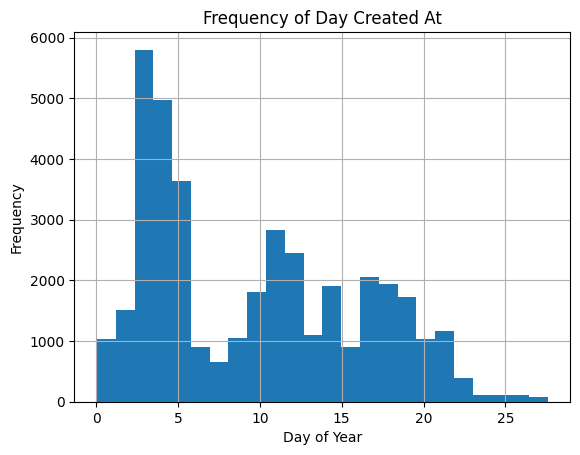

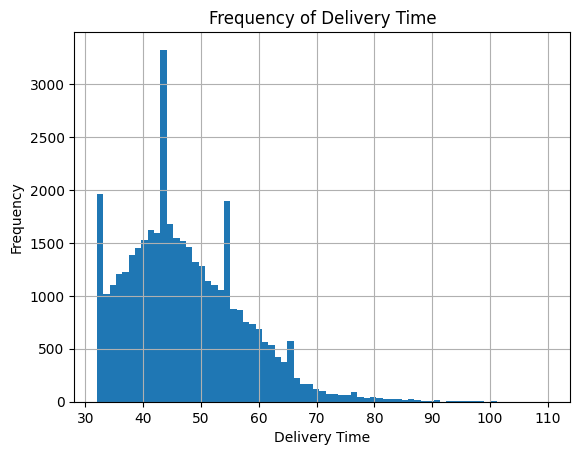

In [ ]:
# graph time frequencies for the weird times df
weird_times_sql_df["created_at"].hist(bins=24)
# add title and labels
plt.title("Frequency of Day Created At")
plt.xlabel("Day of Year")
plt.ylabel("Frequency")
plt.show()
weird_times_sql_df["delivery_time"].hist(bins=len(weird_times_sql_df["delivery_time"].unique()))
# add title and labels
plt.title("Frequency of Delivery Time")
plt.xlabel("Delivery Time")
plt.ylabel("Frequency")
plt.show()

It seems very unusual, there are significant spikes in the data which could suggest these errors were caused by some software bug. Since the truth of these data points is questionable, we will have to drop them. If we, for example, chose to impute values, we would be implicity assuming the veracity of the remaining features for these data points, which isn't guaranteed.

In [ ]:
porter_df = porter_df.query("total_busy_dashers <= total_onshift_dashers").reset_index(drop=True)

# **2.3.2: Assessing other anomalies**

There are a few other parts of our data we will want to clean. We'll choose to drop these data points as well for the same reason we dropped the data before (unknown source of the outliers). As noted above, there are certain columns which are negative but should not be (total_outstanding_orders, total_busy_dashers, and total_onshift_dashers). We will check to see if any of these columns contain negative values and remove them from the dataset.

In [ ]:
# total_outstanding_orders, total_busy_dashers, and total_onshift_dashers should be positive quantities. We will drop them when they are negative.
query = """SELECT COUNT(*) FROM porter_df WHERE total_outstanding_orders < 0 or total_busy_dashers < 0 or total_onshift_dashers < 0"""
num_results = ps.sqldf(query, locals())['COUNT(*)'][0]

print(f'There are {num_results} orders with negative total_outstanding_orders, total_busy_dashers, total_onshift_dashers')
porter_df = porter_df.drop(porter_df.query("total_outstanding_orders < 0 or total_busy_dashers < 0 or total_onshift_dashers < 0").index).reset_index(drop=True)

There are 41 orders with negative total_outstanding_orders, total_busy_dashers, total_onshift_dashers


Let's take a look at the distribution of delivery_time to see if it is reasonable.

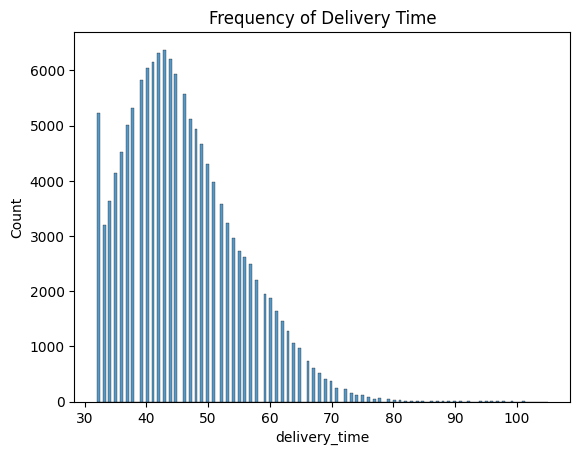

In [ ]:
# add a plot title
plt.title("Frequency of Delivery Time")
sns.histplot(porter_df["delivery_time"])
plt.show()

We find there is a big spike in delivery times at the shortest delivery time (32 minutes) in this rigth-skewed distribution. We hypothesize that delivery times shorter than 32 minutes are rounded up, which means our target variable could be wrong for some sections of our data. That is, certain delivery times which take less than 32 minuted are inaccurately represented as 32 minutes. We'll need to drop these data points.

In [ ]:
query = """
SELECT COUNT(*)
FROM porter_df
WHERE delivery_time = (SELECT MIN(delivery_time) FROM porter_df)
"""
num_results = ps.sqldf(query, locals())['COUNT(*)'][0]
print(f'There are {num_results} orders equal to the minimum delivery time.')
porter_df = porter_df[porter_df["delivery_time"] != min(porter_df["delivery_time"])].reset_index(drop=True)

There are 5222 orders equal to the minimum delivery time.


Lastly, we will check if min_item_price * total_tiems is more than subtotal and max_item_price is less than min_item_price. These should clearly be impossible.

In [ ]:
query = """
SELECT COUNT(*)
FROM porter_df
WHERE (min_item_price * total_items) > subtotal
"""
num_results = ps.sqldf(query, locals())['COUNT(*)'][0]
print(f'There are {num_results} orders where the subtotal is less than the product of min_item_price and total_items')
porter_df = porter_df[(porter_df["min_item_price"] * porter_df["num_distinct_items"]) <= porter_df["subtotal"]].reset_index(drop=True)

There are 681 orders where the subtotal is less than the product of min_item_price and total_items


In [ ]:
query = """
SELECT COUNT(*)
FROM porter_df
WHERE max_item_price < min_item_price
"""
num_results = ps.sqldf(query, locals())['COUNT(*)'][0]

print(f'There are {num_results} orders where max_item_price is less than min_item_price')
porter_df = porter_df[porter_df["max_item_price"] >= porter_df["min_item_price"]].reset_index(drop=True)

There are 369 orders where max_item_price is less than min_item_price


# **2.3.3 Removing outliers**

Based on what we found above, there are likely many other reporting errors that are hard to catch based solely on simple logical checks. What we will do is imploy an unsupervised ML model called the LocalOutlierFactor which will identify outliers based on if they are very far from other data points. This step would likely be necessary nonetheless, but it will also help with removing egregious reporting errors in our data that we were unable to catch.

In [ ]:
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')  # contamination is the proportion of outliers in the data
outliers = lof.fit_predict(porter_df.drop(columns={'created_at', 'actual_delivery_time'})) # fit_predict returns 1 for inliers and -1 for outliers
porter_df['outlier'] = outliers # add the outlier column to the dataframe
porter_df = porter_df[porter_df['outlier'] == 1].drop(columns='outlier') # drop the outliers

# Part 2: Data Loading & Cleaning Summary

**2.1 Data Loading**
- The data from "porter_data.csv" is loaded into a Pandas DataFrame and the initial examination shows that the data includes datetime features needing processing and other features are appropriately encoded and non-null. The dataset includes various features such as market ID, store category, order protocol, and several pricing and order count variables.

**2.2 Initial Data Cleaning**
- This section focuses on handling missing values and errors in the data. Missing market IDs are imputed using the mode of the dataset, while entries with erroneous negative values for features like `total_outstanding_orders` are dropped due to their implausibility, hinting at potential data collection errors.

**2.3 Outlier Detection and Removal**
- Outliers in delivery time with a Z-score greater than 6 are identified and removed, presuming they result from extraordinary events not typical to the dataset. Further, data points with logically impossible values, such as negative counts and pricing inconsistencies, are removed. An unsupervised ML model, LocalOutlierFactor, is used to identify and remove outliers based on distance from other data points, further cleaning the dataset for more accurate analysis.

These steps ensure the data integrity and suitability for further analysis in Part 3, focusing on exploratory data analysis and additional preprocessing.


# **Part 3: EDA & More Prepocessing**

Now that we've done some basic preprocessing and removed some low quality data and outliers, let's get a better sense of some of the features of our data and how they contribute to a speedy delivery.

# **3.1 Summary Statistics**

Let's first look at the distribution of our remaining features.

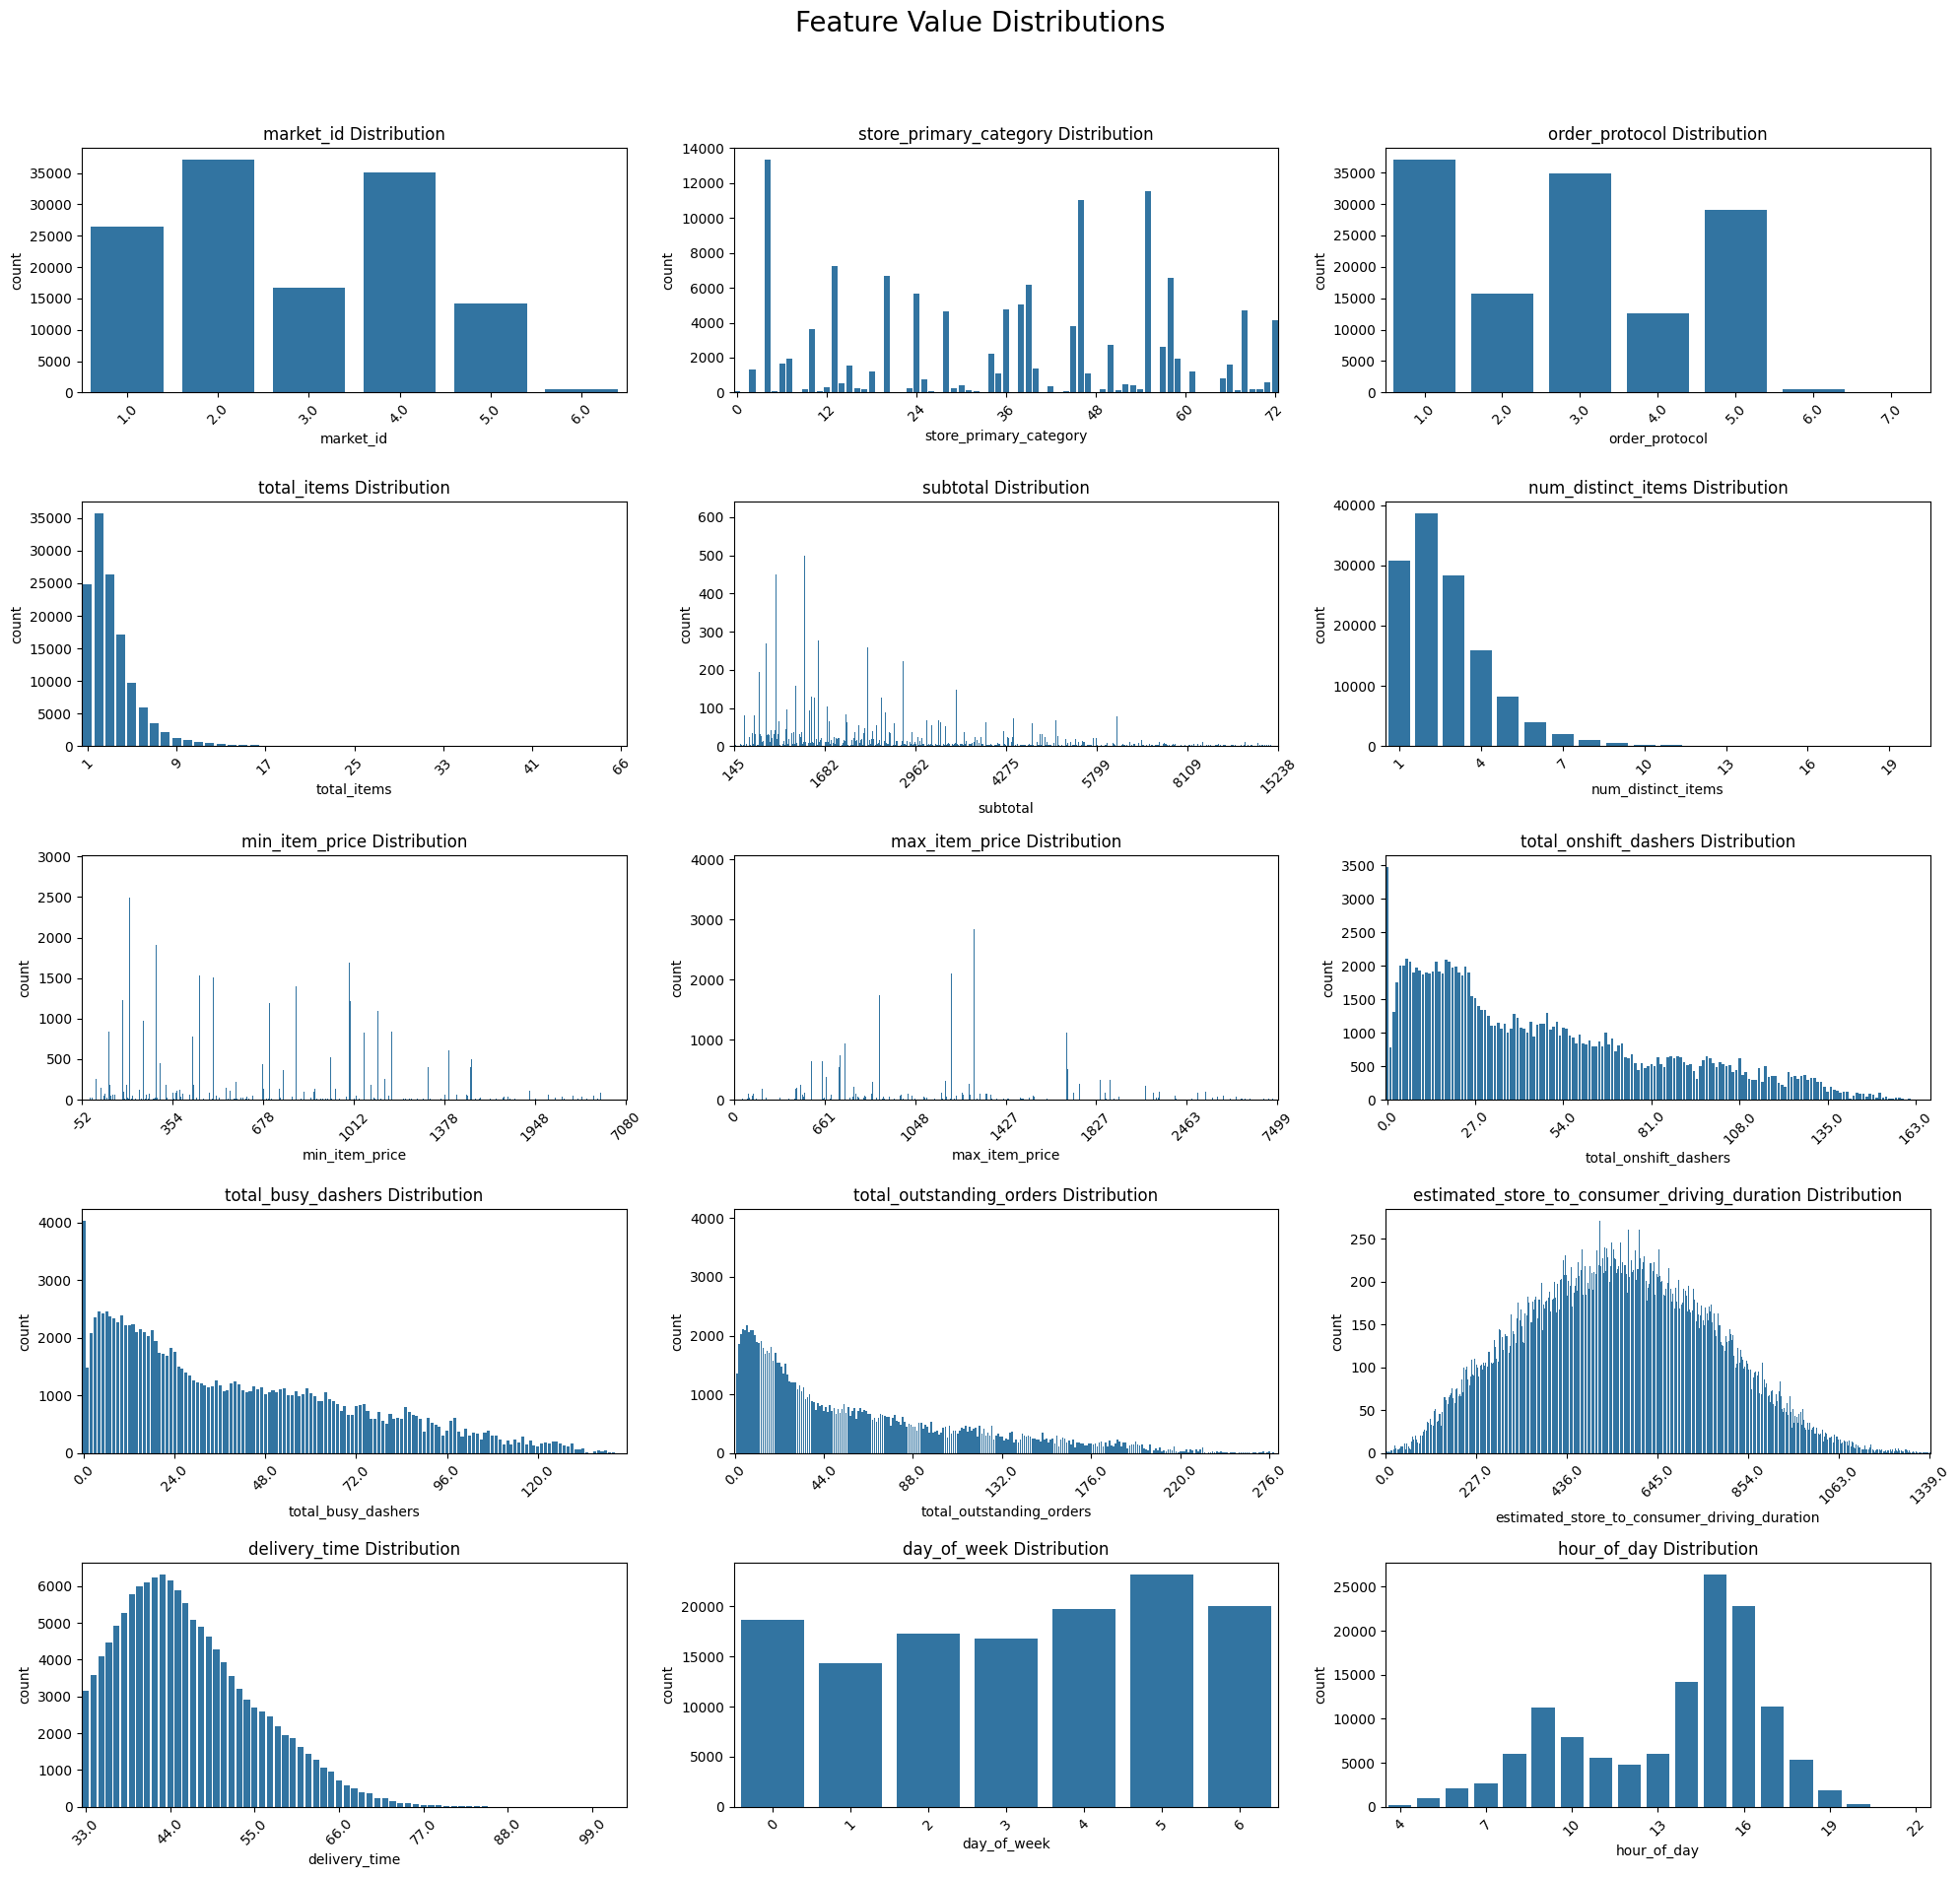

In [ ]:
# Plot the count of the different values of each column into a bar chart and create a master plot with all the individual plotss
# create a dictionary to map the column names to their unique values
unique_values = {}
for col in porter_df.columns:
    unique_values[col] = porter_df[col].unique()
unique_values
# remove the "created_at" and "actual_delivery_time" columns from the dictionary
unique_values.pop("created_at")
unique_values.pop("actual_delivery_time")
# sort each of the unique values in the dictionary in ascending order
for key in unique_values.keys():
    unique_values[key] = np.sort(unique_values[key])
# plot the count of the different values of each column into a bar chart
fig, axes = plt.subplots(5, 3, figsize=(20, 20))
fig.suptitle("Feature Value Distributions", fontsize=20)
for i, (key, value) in enumerate(unique_values.items()):
    sns.countplot(x=key, data=porter_df, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f"{key} Distribution")
    # set the tick labels to be 7 unique values
    axes[i//3, i%3].set_xticks(range(0, len(value), len(value)//6))
    axes[i//3, i%3].set_xticklabels(value[::len(value)//6], rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

**Bar Graph Analysis**

There is a lot to unpack from these value distributions.
1. Most orders have 10 or less items. That is, when people place an order, they are getting smaller orders.
2. The markets in which orders are placed for are relatively uniform. However there are a few exception.
    - Market 6 has significantly fewer orders than all the other markets
    - Markets 1, 2, and 4 are the most popular
3. Most of our continuous features have a right skew, except estimated_driving_time and hour_of_day. This makes sense since a region can be unboundedly busy, but all these features are lower bounded by 0.
4. 1, 3, and 5 are the most popular order protocols and 6 and 7 are the least used.
5. Removing outliers smoothed out the delivery_time distribution considerably.
6. The distribution of item prices and subtotals have many spikes. This makes sense, it's more likely to price an item at 1999 or 2000 Rupee than 1427 Rupees. Subtotals are slightly less spiky because as you sum these prices, the distribution will smooth out.
7. Deliveries are roughly uniformly distributed throughout the week.

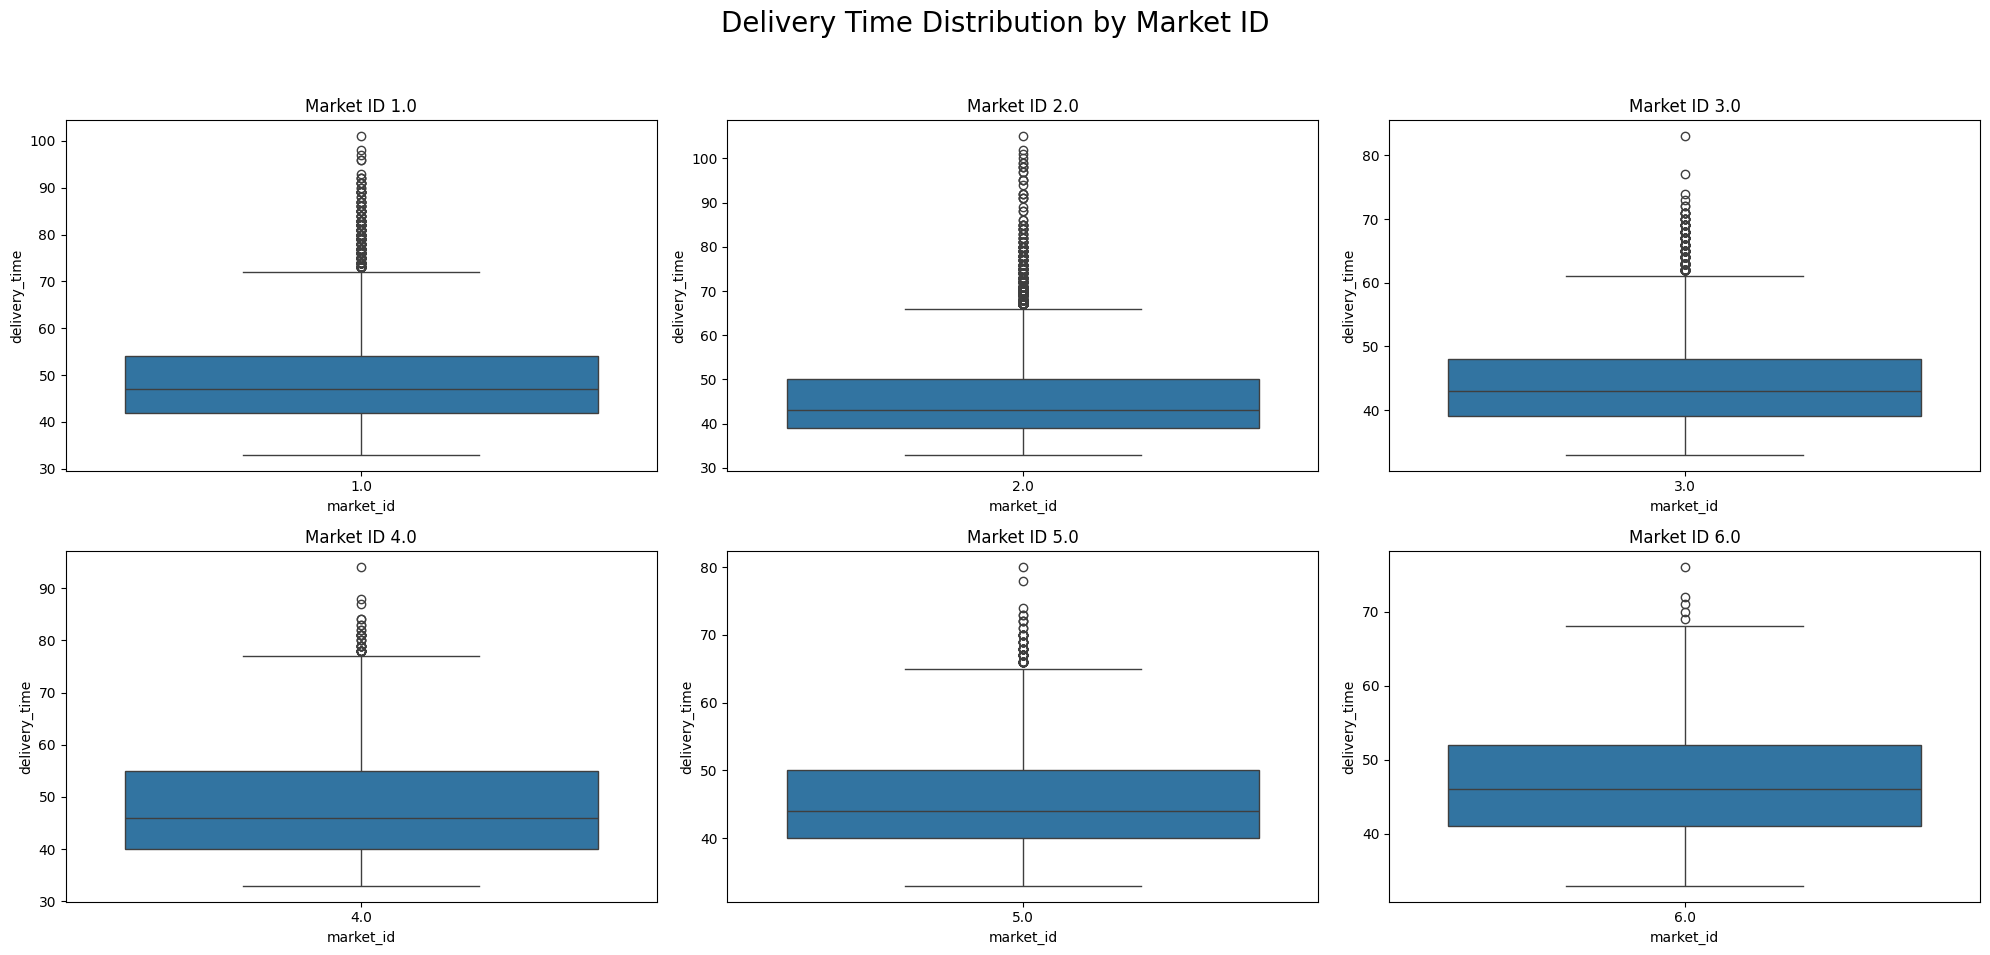

In [ ]:
# create box plots for the delivery time based on each of the 6 "market_id" values
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle("Delivery Time Distribution by Market ID", fontsize=20)
for i, market_id in enumerate(porter_df["market_id"].unique()):
    sns.boxplot(x="market_id", y="delivery_time", data=porter_df[porter_df["market_id"] == market_id], ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f"Market ID {market_id}")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

**Market ID Analysis**
- Most markets have comparable delivery times with mean values in the mid-40 minutes.

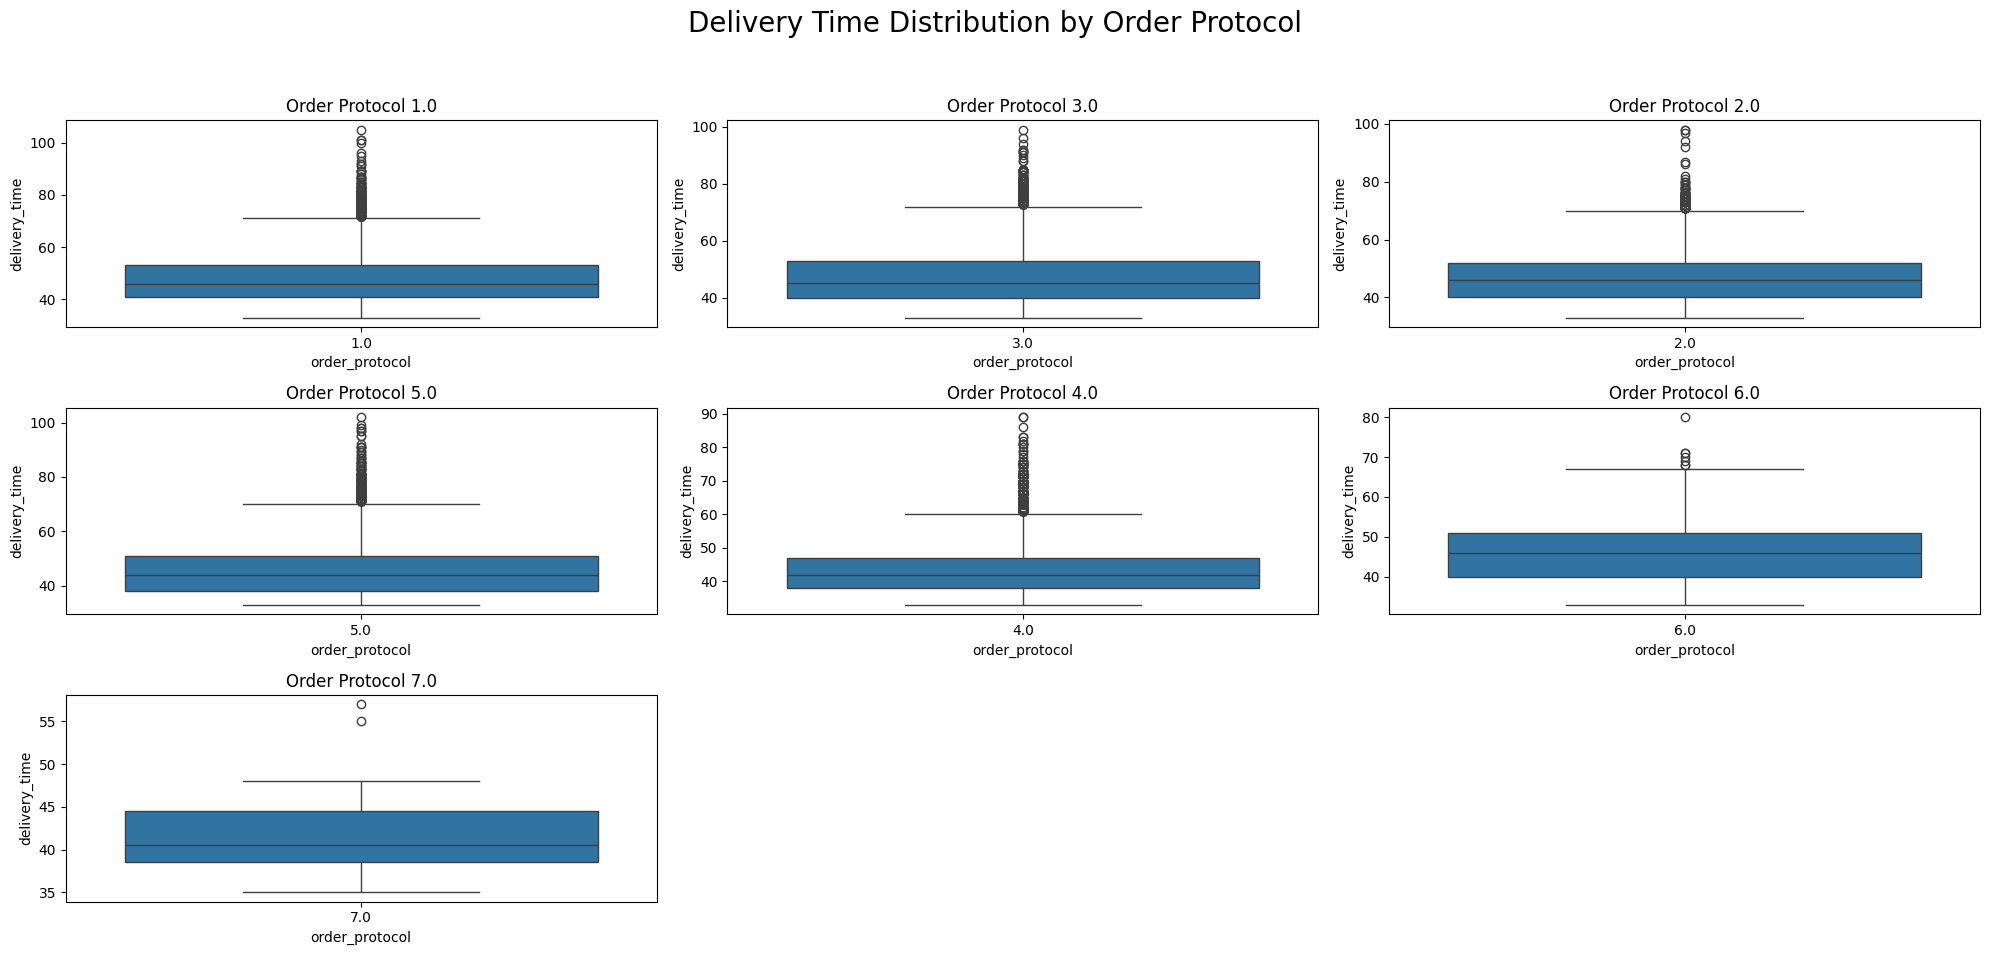

In [ ]:
# create box plots for the delivery time based on each of the 7 "order_protocol" values
fig, axes = plt.subplots(3, 3, figsize=(20, 10))
fig.suptitle("Delivery Time Distribution by Order Protocol", fontsize=20)
for i, market_id in enumerate(porter_df["order_protocol"].unique()):
    sns.boxplot(x="order_protocol", y="delivery_time", data=porter_df[porter_df["order_protocol"] == market_id], ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f"Order Protocol {market_id}")
axes[2, 1].axis("off")
axes[2, 2].axis("off")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

**Order Protocol Analysis**
- Most order protocols are distributed similarly, with most most protocols having mean delivery times in the low/mid 40s.

Now that we have understood how markets and propocols compare to delivery time, we will work toward understanding feature correlation and removing highly correlated variables.

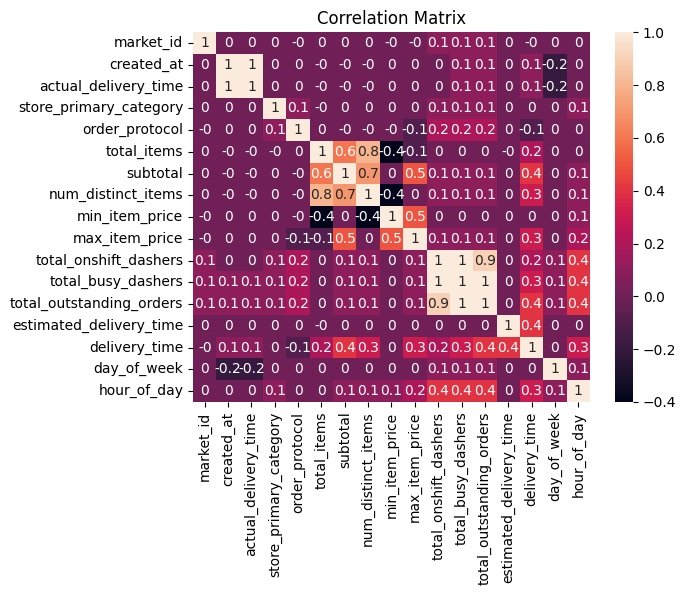

In [ ]:
porter_df.rename(columns={"estimated_store_to_consumer_driving_duration": "estimated_delivery_time"}, inplace=True)
corr = porter_df.corr().round(1)
sns.heatmap(corr, annot=True)
plt.title("Correlation Matrix")
plt.show()

**Correlation Heatmap Analysis**
- created_at actual_delivery time are both, close to, uncorrelated with delivery_time. They also are also won't contribute to our model from the perspective of our objective; If we find a positive correlation over time, we won't know if it's a seasonal effect or representative since our data is only sampled over a few weeks.

- Our variables are close to uncorrelated except for two clusters:
    - total_onshift_dashers, total_busy_dashers, total_outstanding_orders.
    - total_items, subtotal, num_distinct_items, min_item_price.

This makes sense; We'd expect a reasonable model of delivery time to take in the distance from the store to the house (estimated_delivery_time), the amount of goods ordered (subtotal cluster), and, generally, how busy the area is (dashers/orders) cluster.

We'll explore these clusters in more depth later.

# **3.2: Time**

Let's take a closer look at how time plays a role in modelling order delivery time with a few plots.

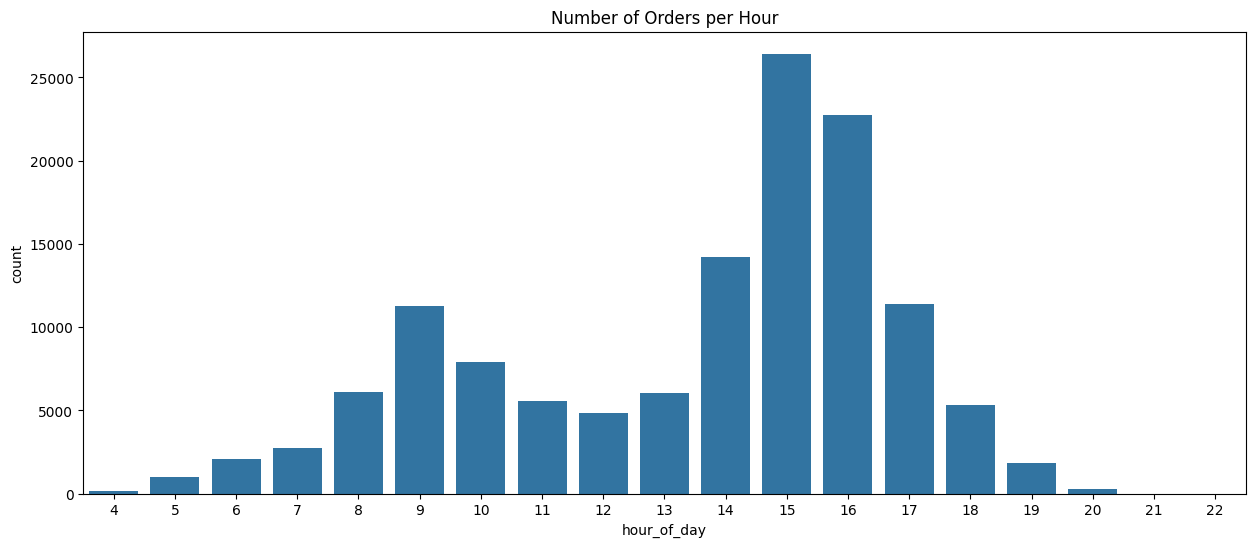

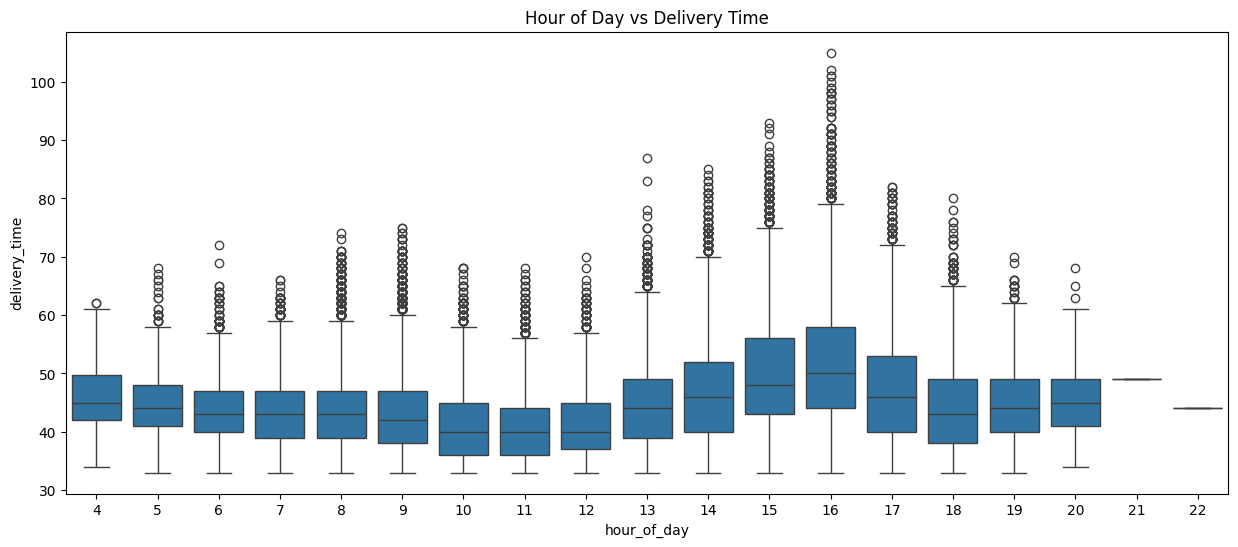

In [ ]:
# plot the number of orders per hour

plt.figure(figsize=(15, 6))

sns.countplot(data=porter_df, x="hour_of_day")

plt.title("Number of Orders per Hour")

plt.show()

# plot hour of day vs delivery time

plt.figure(figsize=(15, 6))

sns.boxplot(data=porter_df, x="hour_of_day", y="delivery_time")

plt.title("Hour of Day vs Delivery Time")

plt.show()


**Hour of Day Analysis**

As we can see, certain times of the day, mainly between 2-5 PM have significantly more orders than other times. At these times, customers get slower deliveries since drivers are crowded out. Logically, this makes sense as the more orders there are, the longer it takes to prepare all the orders and the few dashers are avaliable to run the delivery.

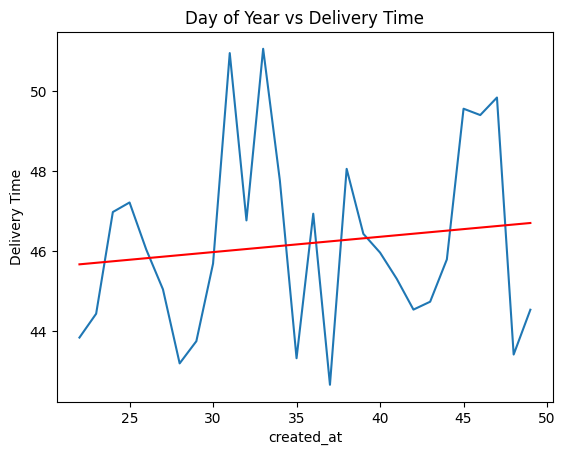

The p value for day of year is 0.5009251865489603.


In [ ]:

porter_df.groupby(porter_df["created_at"].dt.day_of_year)["delivery_time"].mean().plot()

X = sm.add_constant(porter_df.groupby(porter_df["created_at"].dt.day_of_year)["delivery_time"].mean().index)

y = porter_df.groupby(porter_df["created_at"].dt.day_of_year)["delivery_time"].mean().values

model = sm.OLS(y, X)

results = model.fit()

plt.plot(X[:, 1], results.predict(X), color='red')

plt.title("Day of Year vs Delivery Time")
# add y axis label
plt.ylabel("Delivery Time")
plt.show()

print(f"The p value for day of year is {results.pvalues[1]}.")

**Day of Year Analysis**
- All the data is sampled over roughly two weeks between 01/29/2015-02/12/2015. This means we likely cannot use day of year or the absolute value of created_at as a factor in our model since it won't generalize well. Suppose we did; It would be hard to decipher if we were observing a short term seasonal trend or a trend that would generalize, like delivery drivers were getting faster.
- Further, from the chart, we can see that there is no obvious relationship between the day of year orders were created at and their delivery time. If we test the hypothesis that day_of_year explains more variance than noise, we get a p-value of .5, which is not enough to reject the null hypothesis. This is a naive test, as there could be interactions with other features that are relevant, or nonlinear relationships, but we will be dropping it before modelling nonetheless and sticking to seasonal features (day of week and time of day).

# **3.3 Miscellaneous Analysis**

In this section, we will doing further analysis on the features to better understand how they relate to one another.

# **3.3.1 Busiest Hours of the Day**

Now let's take a look at the features related to dashers and outstanding orders. We will use this to identify what hours of the day are the busiest for dashers. To do this, we will plot hour of the day vs the average percent of dashers busy and the average outstanding orders.

In [ ]:
dasher_df = porter_df.copy()

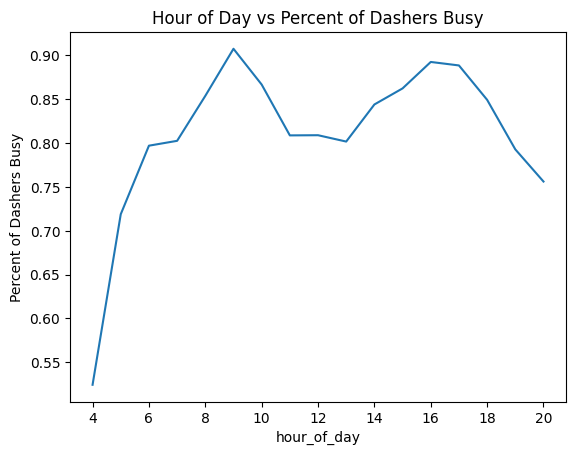

In [ ]:
# check which hours of the day are most busy for dashers by comparing hours of the day to the average percent of dashers busy (busy dashers / total onshift dashers)
# create a new df for the average percent of dashers busy
dasher_df["percent_busy_dashers"] = dasher_df["total_busy_dashers"] / dasher_df["total_onshift_dashers"]
# group by the hour of the day and get the mean of the percent of busy dashers
dasher_df.groupby("hour_of_day")["percent_busy_dashers"].mean().plot()

X = sm.add_constant(dasher_df.groupby("hour_of_day")["percent_busy_dashers"].mean().index)
y = dasher_df.groupby("hour_of_day")["percent_busy_dashers"].mean().values

# add labels to the plot
plt.title("Hour of Day vs Percent of Dashers Busy")
plt.ylabel("Percent of Dashers Busy")
plt.show()

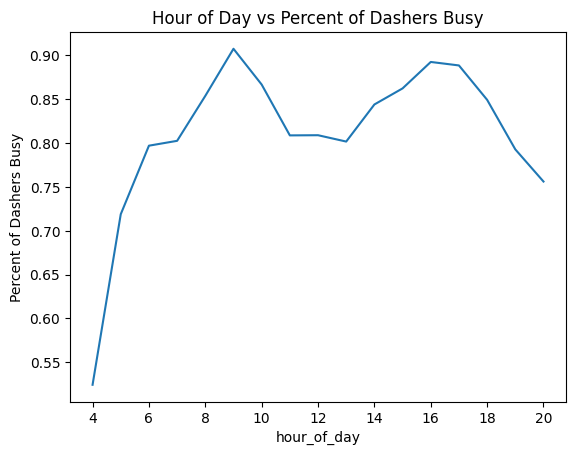

In [ ]:
# check which hours of the day are most busy for dashers by comparing hours of the day to the average percent of dashers busy (busy dashers / total onshift dashers)
# create a new df for the average percent of dashers busy
dasher_df["percent_busy_dashers"] = dasher_df["total_busy_dashers"] / dasher_df["total_onshift_dashers"]
# group by the hour of the day and get the mean of the percent of busy dashers
dasher_df.groupby("hour_of_day")["percent_busy_dashers"].mean().plot()

X = sm.add_constant(dasher_df.groupby("hour_of_day")["percent_busy_dashers"].mean().index)
y = dasher_df.groupby("hour_of_day")["percent_busy_dashers"].mean().values

# add labels to the plot
plt.title("Hour of Day vs Percent of Dashers Busy")
plt.ylabel("Percent of Dashers Busy")
plt.show()

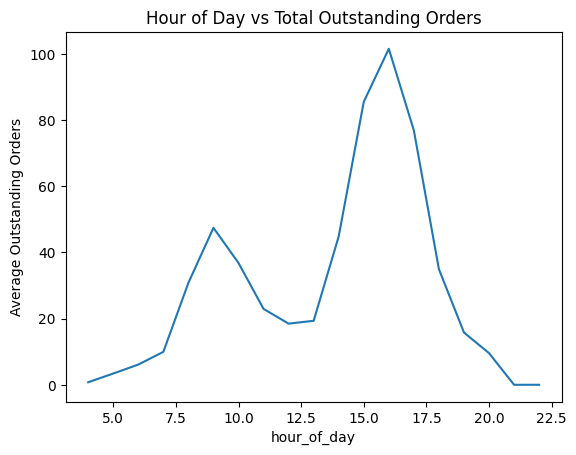

In [ ]:
dasher_df.groupby("hour_of_day")["total_outstanding_orders"].mean().plot()

X = sm.add_constant(dasher_df.groupby("hour_of_day")["total_outstanding_orders"].mean().index)
y = dasher_df.groupby("hour_of_day")["total_outstanding_orders"].mean().values
# add labels to the plot
plt.title("Hour of Day vs Total Outstanding Orders")
plt.ylabel("Average Outstanding Orders")
plt.show()

From this plot, we learn that the hours between 8-11 am and 2-5 pm are the busiest for Porter. Generally speaking, at least 80% of the dashers are busy at any give time but during the peak hours over 85% of the dashers are busy. We also see that 2-5 pm is generally busier than 811 am as there are more outstanding orders on average during that block.

# **3.3.2 Orders and Delivery Time**

In this section, we will be comparing the outstanding orders vs the delivery time to complete orders. We would assume that the more outstanding orders there are, the longer it should take to deliver an order.

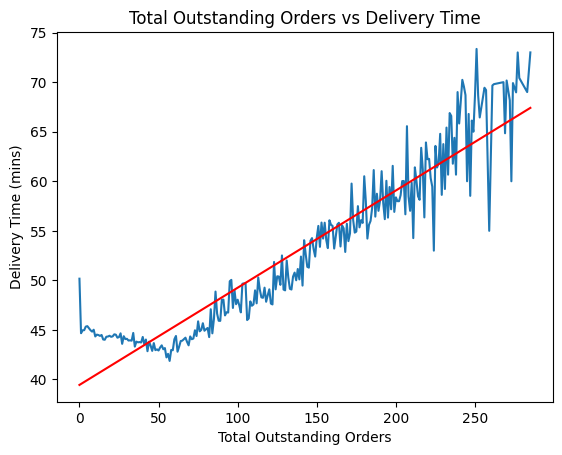

In [ ]:
# plot total outstanding orders vs delivery time

porter_df.groupby("total_outstanding_orders")["delivery_time"].mean().plot()

X = sm.add_constant(porter_df.groupby("total_outstanding_orders")["delivery_time"].mean().index)

y = porter_df.groupby("total_outstanding_orders")["delivery_time"].mean().values

model = sm.OLS(y, X)

results = model.fit()

plt.plot(X[:, 1], results.predict(X), color='red')
plt.title("Total Outstanding Orders vs Delivery Time")
plt.ylabel("Delivery Time (mins)")
plt.xlabel("Total Outstanding Orders")
plt.show()

Generally, the logical trend we mentioned earlier holds: as the total orders increass, so does the delivery time.

# **3.3.3 Comparing Order Statistics Correlation**

In this section, we will be comparing the correlation for variables that are likely related to each other ('total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'hour_of_day', 'delivery_time'). The idea is to identify how these variables correlate to one another and how strongly.

In [ ]:
dasher_df = porter_df[['total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'hour_of_day', 'delivery_time']].copy()

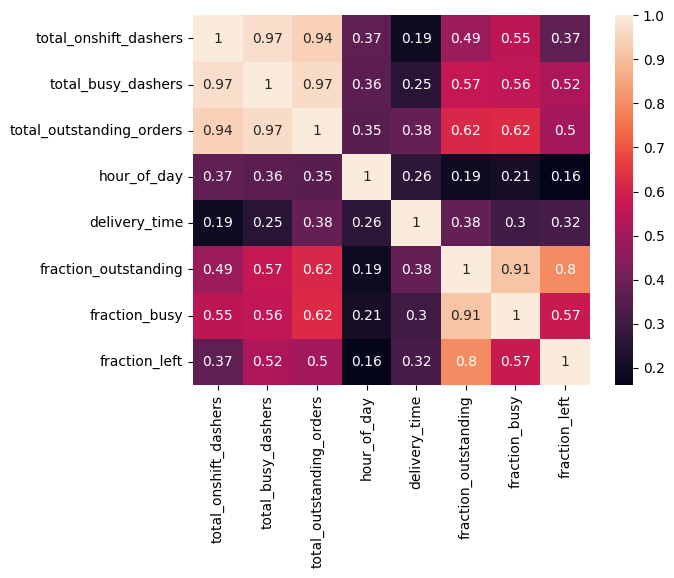

In [ ]:
dasher_df['fraction_outstanding'] = np.log(1 + dasher_df['total_outstanding_orders'] / (1 + dasher_df['total_onshift_dashers']))
dasher_df['fraction_busy'] = np.log(1 + dasher_df['total_outstanding_orders'] / (1 + dasher_df['total_busy_dashers']))
dasher_df['fraction_left'] = np.log(1 + dasher_df['total_outstanding_orders'] / (1 + dasher_df['total_onshift_dashers'] - dasher_df['total_busy_dashers']))
corr = dasher_df.corr()
sns.heatmap(corr, annot=True)
plt.show()

**Correlation Heatmap Analysis**
- The onshift dashers and busy dashers are highly correlated which is expected as the total busy dashers is generally 80% of the total onshift dashers.
- An interesting correlation is that the onshift/busy dashers and outstanding orders is highly correlated. This makes sense as we would expect there to be more dashers loged into the system during peak hours when the orders are high.
- The remaining features are relatively uncorrelated which means that the features do not contain redundant information.

# **3.3.4 Store Category vs Delivery Time**

Here, we will examin how the store category relates to the delivery time. We noticed in an earlier heat map that it did not correlate to delivery time at all and want to see if the delivery time for each story category is uniform using a bar chart.

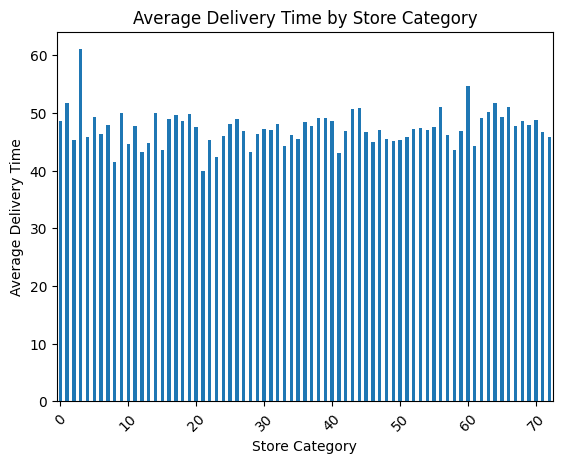

In [ ]:
# graph a bar chart for story category vs average delivery time
dup_df = porter_df.copy()
# sort the df by store_primary_category in ascending order
dup_df.sort_values("store_primary_category", inplace=True)
# group by store category and get the mean of the delivery time
dup_df.groupby("store_primary_category")["delivery_time"].mean().plot(kind="bar")
# add title and labels
plt.title("Average Delivery Time by Store Category")
plt.xlabel("Store Category")
plt.ylabel("Average Delivery Time")
# set the x-axis ticks to be evey 10th store category
plt.xticks(range(0, len(dup_df["store_primary_category"].unique()), 10), dup_df["store_primary_category"].unique()[::10], rotation=45)
plt.show()

As we can see, the store category does not determine the delivery time as the graph is relatively uniform. We can use this information to exculde this column from the features when training our models. Another challenge with using the story category variable is that it is categorial. We should one-hot-encode this feature but (1) it would add 70 additional columns, (2) the r^2 value for this feature from above proves this feature is irrelevant, and (3) we can see the uniformity of the average delivery time compared to category.

# Part 3: EDA & More Preprocessing Summary

**3.1 Summary Statistics**
- This section provided an overview of the value distributions across the dataset through bar graphs. Key observations include uniformity in market orders with some exceptions, a right skew in most continuous features, and insights into order sizes, pricing, and order protocols. The analysis also noted that outlier removal smoothed out the delivery time distribution.

**3.2 Exploratory Data Analysis (EDA)**
- Detailed analysis of delivery times by market ID and order protocol revealed generally uniform delivery times across different categories with averages around mid-40 minutes. This uniformity suggests that market ID and order protocol do not significantly influence delivery times.
- The section also explored feature correlations to understand dependencies among variables. A correlation heatmap provided insights into the relationships, particularly highlighting a strong correlation between on-shift and busy dashers, as well as with the total outstanding orders.

**3.3 Advanced Feature Analysis**
- Further exploration focused on the correlations between order statistics such as total onshift dashers, total busy dashers, and total outstanding orders, confirming expected trends that higher total orders correlate with longer delivery times.
- An examination of how store category relates to delivery time showed no significant correlation, leading to a decision to exclude this variable from model training. The analysis justified this by noting that encoding the category feature would unnecessarily complicate the model without providing valuable insights, as shown by the uniform delivery time across categories.

These findings from Part 3 emphasize the dataset's characteristics and relationships, providing a foundation for Part 4.


# **Part 4: Preparing Data for Modelling**

Based on our findings in EDA, we'll now want to prepare our data for modelling by engineering some features, encoding categorical features, and removing poor features. We'll try and differentiate between a more interpretable/reduced (called porter_df) dataframe which we will use for linear regression and a more feature rich dataframe (called expanded_porter_df) we'll use it more complex models.

In [ ]:
expanded_porter_df = porter_df.copy(deep=True)

# **4.1: Selecting Features**

We will drop a few features in our reduced dataframe:
- num_distinct_items, max_item_price, min_item_price: They have a weak relationship with delivery time, but we belive that this relationship should be better captured in subtotal and total_items.
- created_at, actual_delivery_time: These features won't generalize well, have a weak relationship with delivery time, and we'd likely get a small amount of leakage since our target variable is a linear combination of these two. For the first and last reason, we'll also be dropping them in the full dataframe.
- store_primary_category: This feature has a weak relationship with delivery_time and is an categorical variable with 40 distinct values. Encoding it in a reasonable manner would be a challenge.

In [ ]:
porter_df.drop(columns=['num_distinct_items', 'max_item_price', 'min_item_price', 'created_at', 'actual_delivery_time', 'store_primary_category'], inplace=True)
expanded_porter_df.drop(columns=['created_at', 'actual_delivery_time'], inplace=True)

# **4.2: Encoding Features**

Recall that our data has a few categorical features. Lets see how we can best encode them.

In [ ]:
# Check for categorical features (low number of unique values)
porter_df.nunique()

market_id                      6
order_protocol                 7
total_items                   49
subtotal                    7675
total_onshift_dashers        167
total_busy_dashers           144
total_outstanding_orders     269
estimated_delivery_time     1257
delivery_time                 71
day_of_week                    7
hour_of_day                   19
dtype: int64

We will need to encode day_of_week, market_id, order_protocol, and hour_of_day. Since they market_id, order_protocol, and (for our purposes) day_of_week are categorical, we'll use dummy encoding for them.

To avoid encoding hour_of_day into 19 dummies for our reduced dataframe, we'll take advantage of our EDA and note that we can likely split hour_of_day into a few bins. We'll grid search on the best split by checking which splits give us the best R2 on a linear regression. To avoid leakage, we'll define a helper function to split the data here and use this as our training data later on.

In [ ]:
expanded_porter_df = pd.get_dummies(expanded_porter_df, columns=['hour_of_day', 'market_id', 'day_of_week', 'order_protocol'], dtype=int)
porter_df = pd.get_dummies(porter_df, columns=['market_id', 'day_of_week', 'order_protocol'], dtype=int)


Since we're doing a grid search, we'll define a function to train-cv-test split. This should come in handy when modelling as well.

In [ ]:
def get_train_val_test(df, ratio=(0.6, 0.2, 0.2), seed=42):
    """A Helper function to split the data into training, validation and test sets

    Returns: X_train, y_train, X_val, y_val, X_test, y_test"""
    train_ratio, val_ratio, test_ratio = ratio
    train, val, test = np.split(df.sample(frac=1, random_state=seed), [int(train_ratio * len(df)), int((train_ratio + val_ratio) * len(df))])
    X_train = train.drop(columns='delivery_time')
    y_train = train['delivery_time']
    X_val = val.drop(columns='delivery_time')
    y_val = val['delivery_time']
    X_test = test.drop(columns='delivery_time')
    y_test = test['delivery_time']
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = get_train_val_test(porter_df) # random seed is 42 (ensures no leakage), default ratio is 60:20:20.

for num_bins in range(1, 4):
    bin_ranges = {
        f"bin_{i}": range(4, 20) for i in range(1, num_bins + 1)  # e.g. "bin_1", "bin_2", "bin_3
    }

    best_r2 = -np.inf
    best_bins = None

    for bins in product(*bin_ranges.values()):
        if all(b1 < b2 for b1, b2 in zip(bins, bins[1:])):

            temp_train_X_df = X_train.copy()
            bins = [0, *bins, 24]
            labels = ['Period 1'] + [f'Period {i + 1}' for i in range(1, num_bins)] + [f'Period {num_bins + 1}']
            temp_train_X_df['hour_of_day'] = pd.cut(temp_train_X_df['hour_of_day'], bins=bins, labels=labels, include_lowest=True)
            temp_train_X_df = pd.get_dummies(temp_train_X_df, columns=['hour_of_day'], drop_first=True, dtype=int)

            model = LinearRegression()
            model.fit(temp_train_X_df, y_train)

            X_val_temp = X_val.copy()

            X_val_temp['hour_of_day'] = pd.cut(X_val_temp['hour_of_day'], bins=bins, labels=labels, include_lowest=True)

            X_val_temp = pd.get_dummies(X_val_temp, columns=['hour_of_day'], drop_first=True, dtype=int)

            r2 = r2_score(y_val, model.predict(X_val_temp))

            if r2 > best_r2:
                best_r2 = r2
                best_bins = (bins, labels)

    print(f"Best R²: {best_r2} with {num_bins} bins")
    print(f"Best bins: {best_bins}")


Best R²: 0.9035790440028475 with 1 bins
Best bins: ([0, 12, 24], ['Period 1', 'Period 2'])


Best R²: 0.9052426701266537 with 2 bins
Best bins: ([0, 12, 13, 24], ['Period 1', 'Period 2', 'Period 3'])
Best R²: 0.9074447786820361 with 3 bins
Best bins: ([0, 12, 13, 17, 24], ['Period 1', 'Period 2', 'Period 3', 'Period 4'])


Based on this analysis, more bins is better, but the difference is marginal, so we'll stick with only using 2 bins to ensure model simplicity.

In [ ]:
porter_df['hour_of_day'] = pd.cut(porter_df['hour_of_day'], bins=[0, 12, 24], labels=['1', '2'])
porter_df = pd.get_dummies(porter_df, columns=['hour_of_day'], dtype=int)

# **4.3 Adding Features**

As discussed in our EDA, we'd like to add some interaction features between total_outstanding_orders, total_busy_dashers, and total_onshift_dashers. We think a majority of the interaction of these features is linear, but we found these features hadhigh correlation with delivery time, so we'll include them in the expanded dataframe.

In [ ]:
expanded_porter_df['fraction_outstanding'] = np.log(1 + expanded_porter_df['total_outstanding_orders'] / (1 + expanded_porter_df['total_onshift_dashers']))
expanded_porter_df['fraction_busy'] = np.log(1 + expanded_porter_df['total_outstanding_orders'] / (1 + expanded_porter_df['total_busy_dashers']))
expanded_porter_df['fraction_left'] = np.log(1 + expanded_porter_df['total_outstanding_orders'] / (1 + expanded_porter_df['total_onshift_dashers'] - expanded_porter_df['total_busy_dashers']))

# Part 4: Preparing Data for Modelling Summary

In Part 4, the focus is on preparing the dataset for modeling. This involves engineering features, encoding categorical features, and removing poorly correlated features. Two distinct dataframes are prepared: a reduced one (`porter_df`) for simpler models like linear regression and a more feature-rich one (`expanded_porter_df`) for complex models.

### 4.1: Selecting Features
- **Reduced Dataframe** (`porter_df`): The following features are dropped due to weak relationships with delivery time or potential for data leakage:
  - `num_distinct_items`, `max_item_price`, `min_item_price`: These are considered less effective than using `subtotal` and `total_items`.
  - `created_at`, `actual_delivery_time`: These could cause data leakage as the target variable is derived from them.
  - `store_primary_category`: Due to its weak relationship with delivery time and challenges in encoding.
- The full dataframe also excludes some of these features to avoid overfitting and improve generalizability.

### 4.2: Encoding Features
- **Categorical Features**: Key categorical features such as `day_of_week`, `market_id`, and `order_protocol` are encoded using dummy variables.
- **Hour of Day**: Instead of creating many dummy variables, `hour_of_day` is binned based on insights from EDA, optimized through grid searching for the best R^2 in a linear regression model.

### 4.3: Adding Features
- **Interaction Features**: Based on the EDA findings, interaction features involving `total_outstanding_orders`, `total_busy_dashers`, and `total_onshift_dashers` are added to the `expanded_porter_df`. These features show high correlation with delivery times and are included to capture potential non-linear interactions.

This summary details the data preparation steps taken in Part 4, which sets the stage for modeling and further analysis in subsequent parts of the notebook.

# **Part 5: Modelling**

After thoroughly analyzing and preparing our data, we are ready to model.

First, we will define another helper function to evaluate models. (We defined a function to split data earlier!)

In [ ]:
def get_evaluation_metrics(y_true, y_pred, model_name):
    """Returns and prints the R², MAE, RMSE, skewness, and kurtosis of the residuals, in order."""
    r2 = r2_score(y_true, y_pred)
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    kurtosis = stats.kurtosis(y_true - y_pred)
    skew = stats.skew(y_true - y_pred)

    print(f"{model_name} R²: {r2}")
    print(f"{model_name} MAE: {mae}")
    print(f"{model_name} RMSE: {rmse}")
    print(f"{model_name} Kurtosis: {kurtosis}")
    return r2, mae, rmse, skew, kurtosis

**5.1: OLS Linear Regression**

First we will use unregularized OLS Linear regression to do inference on and model our data. We chose this model because it is the most interpretable and will help us understand what features are most relevant in our data and it serves as a solid benchmark to compare future models. We preferred unregularized regression since it can give relevant information like t scores for each feature that other regularized methods cannot and, given the distribution of the underlying data, we anticipate it to underfit, so regularizing likely won't help.

Since linear regression does not have hyperparameters, we aren't able to tune them.

Linear Regression R²: 0.904693365067602
Linear Regression MAE: 1.931482482008211
Linear Regression RMSE: 2.7046361984115763
Linear Regression Kurtosis: 4.329950208674525
Jarque-Bera test statistic: 23599.136972558987, p-value: 0.0


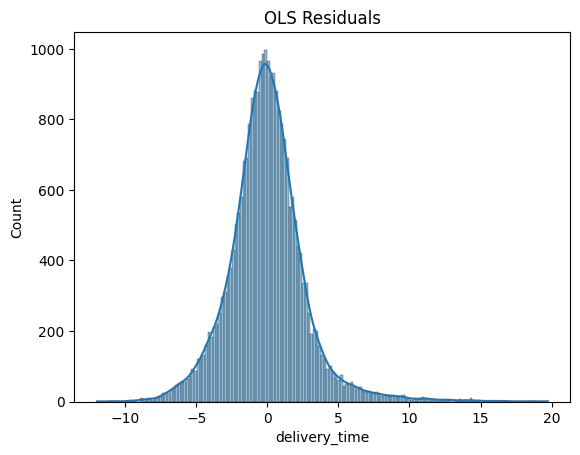

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = get_train_val_test(porter_df, ratio=(.8, 0, .2))

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

get_evaluation_metrics(y_test, y_pred, "Linear Regression")

statistic, p_value = stats.jarque_bera(y_test - y_pred)
print(f"Jarque-Bera test statistic: {statistic}, p-value: {p_value}")

residuals = y_test - y_pred
sns.histplot(residuals, kde=True)

plt.title("OLS Residuals")

plt.show()

We find that our linear regression is a reasonable baseline model; We get an R^2 of about .9 which is pretty good! For some context, before any engineering we had an R^2 of about .8.

One thing that's interesting is that our residuals aren't perfectly normally distributed. The distribution doesn't have major spikes, which is good, but it has very high kurtosis, and, applying the Jarque-Bera test (checks skewness and kurtosis against a normal distribution and tests the hypothesis that the data is sampled from a normal distribution) we get an exceedingly high value, indicating non-normality.

What this could mean, is that there are non-linear relationships in our underlying data, so we can try using models that better learn non-linear relationships like random forest and gradient boosted trees (LightGBM).

Now let's analyze take advantage of the intepretability of linear regression to identify some of the most relevant features.

In [ ]:
model = sm.OLS(y_train, X_train).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          delivery_time   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                 4.096e+04
Date:                Wed, 01 May 2024   Prob (F-statistic):               0.00
Time:                        22:40:18   Log-Likelihood:            -2.5225e+05
No. Observations:              103938   AIC:                         5.046e+05
Df Residuals:                  103913   BIC:                         5.048e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
total_items                  0.0999      0.004     22.686      0.000       0.091       0.109
subtotal                     0.0016   6.14e-06    253.453      0.000       0.002       0.002
total_onshift_dashers       -0.2946      0.001   -293.069      0.000      -0.297      -0.293
total_busy_dashers          -0.2199      0.001   -150.056      0.000      -0.223      -0.217
total_outstanding_orders     0.3620      0.001    579.138      0.000       0.361       0.363
estimated_delivery_time      0.0194   3.97e-05    489.332      0.000       0.019       0.020
market_id_1.0                8.6552      0.033    264.111      0.000       8.591       8.719
market_id_2.0                3.9901      0.033    119.429      0.000       3.925       4.056
market_id_3.0                4.5075      0.035    127.464      0.000       4.438       4.577
market_id_4.0                4.7254      0.033    142.080      0.000       4.660       4.791
market_id_5.0                5.0268      0.036    140.289      0.000       4.957       5.097
market_id_6.0                5.9474      0.123     48.487      0.000       5.707       6.188
day_of_week_0                6.1357      0.027    224.928      0.000       6.082       6.189
day_of_week_1                3.6616      0.029    125.573      0.000       3.604       3.719
day_of_week_2                3.5549      0.028    128.294      0.000       3.501       3.609
day_of_week_3                3.9789      0.028    142.540      0.000       3.924       4.034
day_of_week_4                4.7840      0.027    176.375      0.000       4.731       4.837
day_of_week_5                4.9357      0.026    188.251      0.000       4.884       4.987
day_of_week_6                5.8017      0.027    216.892      0.000       5.749       5.854
order_protocol_1.0           6.1780      0.095     64.854      0.000       5.991       6.365
order_protocol_2.0           5.4551      0.097     56.409      0.000       5.266       5.645
order_protocol_3.0           4.7421      0.096     49.634      0.000       4.555       4.929
order_protocol_4.0           4.2199      0.097     43.320      0.000       4.029       4.411
order_protocol_5.0           3.2997      0.096     34.467      0.000       3.112       3.487
order_protocol_6.0           4.6217      0.154     29.976      0.000       4.319       4.924
order_protocol_7.0           4.3360      0.668      6.487      0.000       3.026       5.646
hour_of_day_1               14.4619      0.062    234.884      0.000      14.341      14.583
hour_of_day_2               18.3906      0.062    295.918      0.000      18.269      18.512
==============================================================================
Omnibus:                    19102.497   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Ja

One important note is that the R^2 for the regression on the training set is close to the same as on the test set. This suggests that our model is not overfitting.

From this we find that the most relevant features are
estimated_store_to_consumer_driving_duration
hour of day
onshift/busy dashers
total_outstanding_orders

This aligns with our findings in EDA that these variables had the strongest correlations with the target variable.

Perhaps there are non-linear relationships though that make certain features more important. Although decision trees are generally less interpretable, we can still test this by checking their feature significances (in general, these are a more flawed measure of importance, but they are helpful nonetheless).

**5.2 Random Forest**

Now, lets try and make a more powerful model using our more feature rich dataframe.

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = get_train_val_test(expanded_porter_df, ratio=(.6, .2, .2))

We chose to do a random forest since we think it will learn the non-linear relationships within our data much better than a linear model will.

We chose to tune the n_estimators and max_depth hyperparameters since we believe they have the greatest impact on the performance of our model.

In [ ]:
def objective(params):
    n_estimators, max_depth = params

    rf = RandomForestRegressor(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        random_state=42
    )

    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    score = mean_squared_error(y_val, y_pred)
    return score

space = [
    (75, 400),  # n_estimators
    (2, 12)    # max_depth
]

result = gp_minimize(objective, space, n_calls=50, random_state=42)

Random Forest R²: 0.9464741898751157
Random Forest MAE: 1.5297629401577832
Random Forest RMSE: 2.02688408634546
Random Forest Kurtosis: 2.1706315197386337


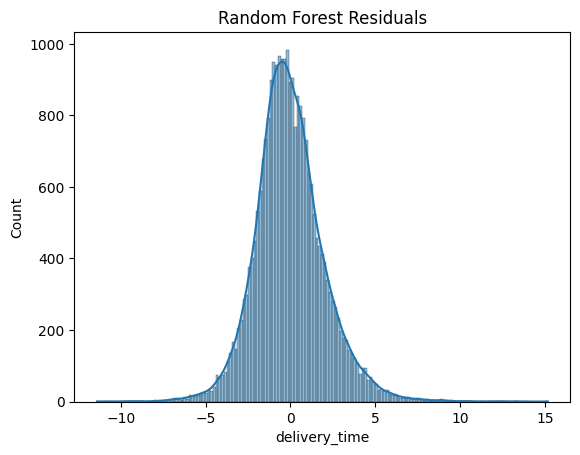

In [ ]:
best_params = result.x

best_rf = RandomForestRegressor(
    n_estimators=int(best_params[0]),
    max_depth=int(best_params[1]),
    random_state=42
)

best_rf.fit(X_train, y_train)

y_pred = best_rf.predict(X_test)

get_evaluation_metrics(y_test, y_pred, "Random Forest")

residuals = y_test - y_pred

sns.histplot(residuals, kde=True)

plt.title("Random Forest Residuals")

plt.show()

And we get a slightly lower MAE, RMSE, and R^2, which is good. Another note is that the distribution has much lower kurtosis, and is closer to normal. This could indicate that the random forest was better at learning the non-linear relationships between our data and the target variable.

Now let's take a look at what features were most important to the random forest model.

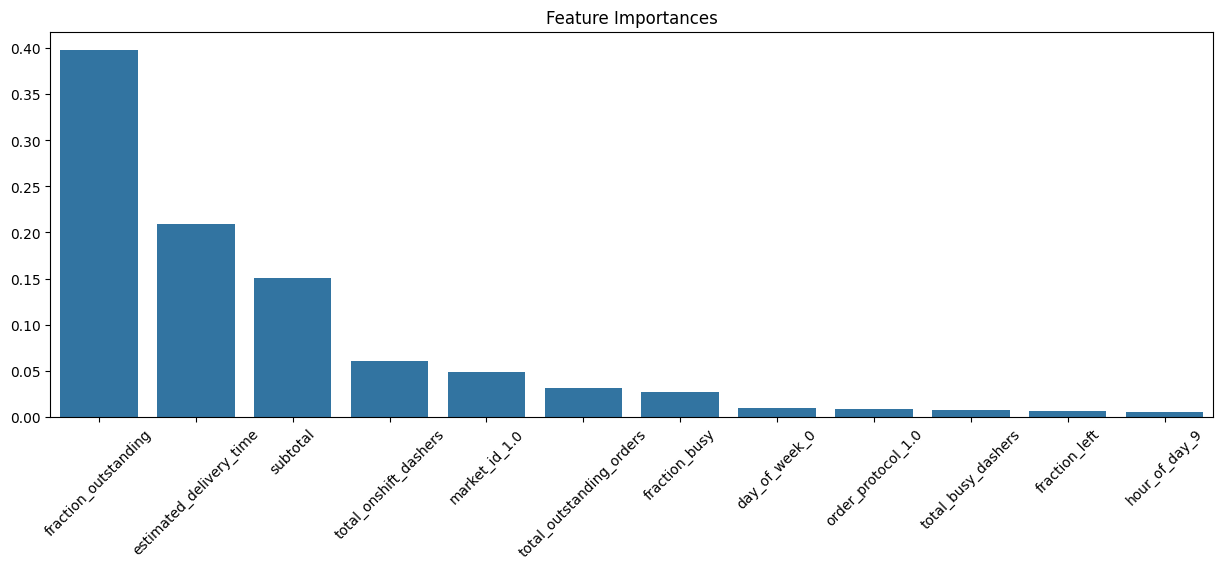

In [ ]:
importances = list(zip(X_train.columns, best_rf.feature_importances_))
importances.sort(key=lambda x: x[1], reverse=True)

plt.figure(figsize=(15, 5))
sns.barplot(x=[x[0] for x in importances[:12]], y=[x[1] for x in importances[:12]])

plt.title("Feature Importances")

plt.xticks(rotation=45)

plt.show()


It seems like the most important features to the random forest model were estimated_delivery_time, fraction_outstanding, and subtotal. We think this is because each of these features are close to orthogonal and capture a large component of the variance within the data. What's surprising, though, is how much weight the random forest placed on these features relative to other ones. Other than total_onshift dashers, and market_id_1 (which is also orthogonal), the model fixated on these three features a lot.

**5.3: Gradient Boosting**

Our journey with this dataset would not be complete without exploring a gradient boosting model (LightGBM). We anticipate that LightGBM will perform the best on our data. This is because our data has many observations ~100k, but likely not enough to train a large neural net, has a reasonable number of features <<300, and is tabular. On these sorts of datasets LightGBM (or other boosting models like XGBoost and CatBoost) typically perform the best.

Although we never learned these models in class, gradient boosting is a ML technique that takes a very weak model (say a 3-deep decision tree) and iteratively uses it to predict the residuals of the previous model, then sums the predictions of the two models. This sounds like it will overfit, but with a weak enough base model and some clever enough regularization/training tricks, it learns an accurate representation of the data. We chose XGBoost from the family of these models because it typically has the fastest training times.

In [ ]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

def objective(params):
    print("Params received:", params)

    params_dict = {
        'num_leaves': int(params[0]),
        'max_depth': int(params[1]),
        'learning_rate': params[2],
        'feature_fraction': params[3],
        'lambda_l1': params[4],
        'lambda_l2': params[5],
        'num_boost_round': int(params[6]),
        'early_stopping_rounds': int(params[7])
    }
    model = lgb.train(params_dict, lgb_train, valid_sets=[lgb_train, lgb_val])
    y_pred = model.predict(X_val)
    score = mean_squared_error(y_val, y_pred)
    return score

space = [
    (50, 250), # num leaves
    (2, 6), # max depth
    (.01, .1), # learning rate
    (.7, 1), # feature fraction
    (0.0, 1), # lambda l1
    (0.0, 1), # lambda l2
    (10, 10000), # num_boost_round
    (20, 100) # early stopping rounds
]

result = gp_minimize(objective, space, n_calls=150, random_state=42)

print("Best parameters found:")

In [ ]:
best_params = {param_name: result.x[i] for i, param_name in enumerate(['num_leaves', 'max_depth', 'learning_rate', 'feature_fraction', 'lambda_l1', 'lambda_l2', 'num_boost_round', 'early_stopping_rounds'])}
best_params

{'num_leaves': 50,
 'max_depth': 4,
 'learning_rate': 0.0898280556,
 'feature_fraction': 0.7,
 'lambda_l1': 0.5,
 'lambda_l2': 0.0567031684814353,
 'num_boost_round': 10000,
 'early_stopping_rounds': 88}

/opt/homebrew/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2536
[LightGBM] [Info] Number of data points in the train set: 77953, number of used features: 49
[LightGBM] [Info] Start training from score 46.472772
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

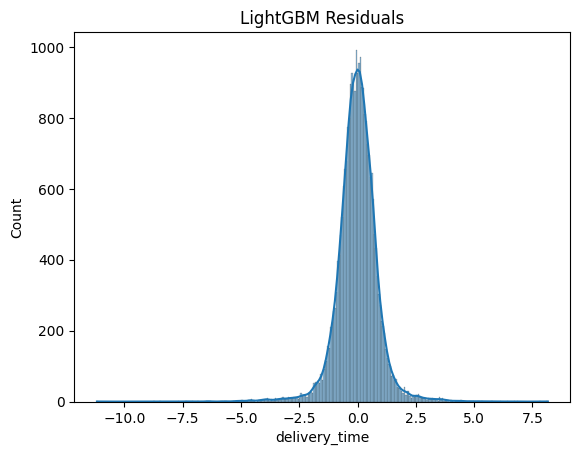

In [ ]:
# Define the dataset
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

params = {'num_leaves': 50,
 'max_depth': 4,
 'learning_rate': 0.0898280556000,
 'feature_fraction': 0.7,
 'lambda_l1': 0.5,
 'lambda_l2': 0.0567031684814353,
 'num_boost_round': 10000,
 'early_stopping_rounds': 100
}

model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_val])

y_pred = model.predict(X_test)

get_evaluation_metrics(y_test, y_pred, "LightGBM")

residuals = y_test - y_pred

sns.histplot(residuals, kde=True)

plt.title("LightGBM Residuals")

plt.show()


Nice! We get an R2 of .99 which is considerably better than other models. What's interesting is that this model seems to be more impacted by outliers and has very high Kurtosis. Perhaps if we were more generous with outlier removal we would've achieved a higher R2, but its also the nature of these deliveries can have some variance. A driver could get a call or have to take a detour while driving, which is hard to predict. We are overall satisfied with this model's ability to approximate the underlying distribution of delivery times. Let's take a look at what features it deemed most important.

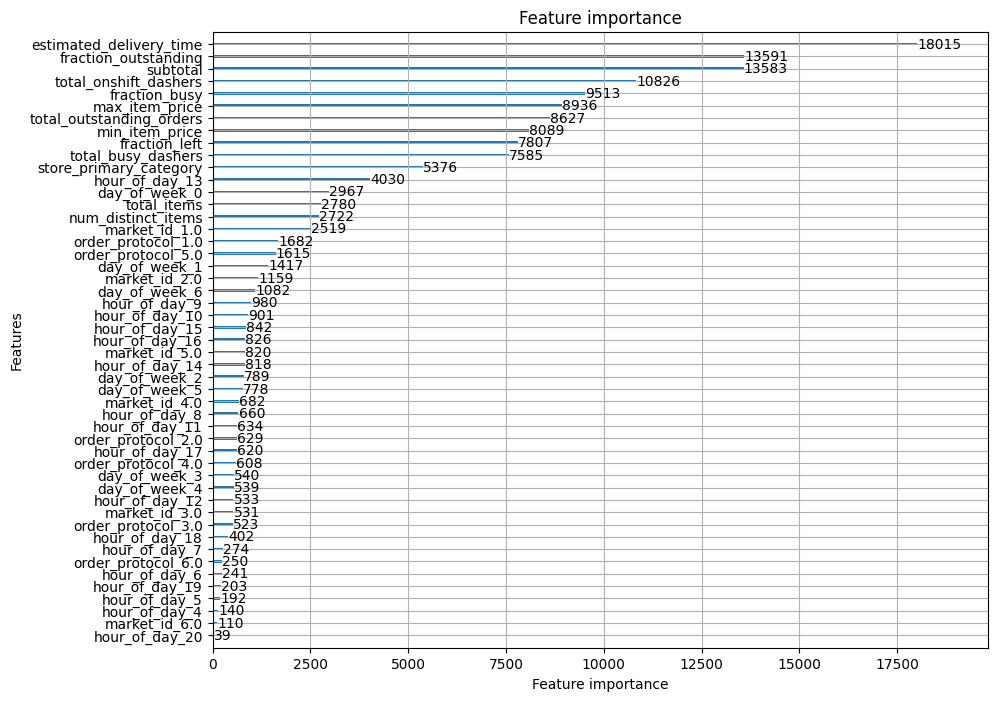

In [ ]:
lgb.plot_importance(model, figsize=(10, 8))

plt.show()

Again, it seemed like the most important features were estimated_delivery_time, fraction_outstanding, and subtotal, and the overall rankings are quite similar to the random forest and regression. We think it makes sense that estimated_delivery_time has the greatest importance since it is close to orthogonal to all other features and plays a big importance in a delivery. No other feature captures time it will take for a driver to go from a business to a customer. We are also happy to see that some of the engineered interaction features played such a powerful role in the model.

# Part 5: Modelling Summary
Part 5 transitions into modeling after the data preparation in Part 4. This section involves defining model evaluation functions and experimenting with different modeling techniques, ranging from simple linear models to more complex ensemble methods.

### 5.1: OLS Linear Regression
- **Introduction to OLS**: The first approach is using unregularized Ordinary Least Squares (OLS) Linear Regression to serve as a baseline model. This model is chosen for its interpretability and the valuable insights it can provide through t-scores for each feature.
- **Performance and Analysis**: The OLS model achieves an R^2 of about 0.9, improving from 0.8 before feature engineering. The residuals, however, show high kurtosis and fail the Jarque-Bera test, suggesting the presence of non-linear relationships in the data.

### 5.2: Random Forest and Gradient Boosting
- **Random Forest**: This model is tested for its ability to capture non-linear relationships and feature interactions more effectively than OLS.
- **Gradient Boosting**: Specifically, LightGBM is utilized among boosting methods like XGBoost and CatBoost. Gradient boosting models are ideal for the dataset due to the structure and size (~100,000 observations and <300 features). The iterative learning of weak models on residuals is highlighted as a key technique.
- **Performance**: LightGBM achieves an R^2 of 0.99, significantly outperforming other models. The analysis also notes that the model's sensitivity to outliers could be mitigated with more extensive outlier removal. The most impactful features identified include `estimated_delivery_time`, `fraction_outstanding`, and `subtotal`.

### Insights and Observations
- **Feature Importance**: Across models, certain features consistently show high importance, such as `estimated_delivery_time` and engineered interaction features.
- **Model Suitability**: We found that our models fit our data relatively well, especially after data cleaning, feature engineering, model selection, and hyperparameter tuning. A naive linear regression would get an R^2 of ~.8 and we were able to get a much higher R^2 of .99.  

This summary encapsulates the modeling strategies employed in Part 5, focusing on how different models are evaluated and the implications of their performance in understanding delivery times within the dataset.